# Neuroplant image analysis
This notebook analyzes chemotaxis assays as part of the neuroplant project, which seeks to use C. elegans nematodes to identify neuroactive compounds in plants.
## First, load libraries

In [1]:
import pandas as pd
import time
import skimage
from skimage import feature
from skimage import morphology
from skimage import measure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np
import pathlib

start = time.time()

## File parameters

In [2]:
plate_number = 1
data_location = pathlib.Path('/Users/adam/Documents/Neuroplant/Images')

## Load data

In [3]:
pre_file = data_location.joinpath('NPP'+ f"{plate_number:03d}" + '_Pre.tif')
fin_file = data_location.joinpath('NPP'+ f"{plate_number:03d}" + '_Fin.tif')
pre_image = skimage.io.imread(pre_file)
pre_image = pre_image[int(3*pre_image.shape[0]/4):pre_image.shape[0],:]#[0:int(pre_image.shape[0]/4),:]
fin_image = skimage.io.imread(fin_file)
fin_image = fin_image[int(3*fin_image.shape[0]/4):fin_image.shape[0],:]#[0:int(fin_image.shape[0]/4),:]

# Crop larger image to make before and after images the same size
pre_x_min = 0
pre_x_max = min(pre_image.shape[1], fin_image.shape[1])
pre_y_min = 0
pre_y_max = min(pre_image.shape[0], fin_image.shape[0])

fin_x_min = 0
fin_x_max = min(pre_image.shape[1], fin_image.shape[1])
fin_y_min = 0
fin_y_max = min(pre_image.shape[0], fin_image.shape[0])

(29885, 21069)
(7472, 21069)


## Subtract background

In [4]:
bkg_subtract = np.subtract(pre_image[fin_y_min:fin_y_max, fin_x_min:fin_x_max].astype('int16'),
                           fin_image[pre_y_min:pre_y_max, pre_x_min:pre_x_max].astype('int16'))
bkg_subtract[bkg_subtract < 0] = 0
bkg_subtract = bkg_subtract.astype('uint8')

## Threshold to get binary image

In [5]:
thresh = skimage.filters.threshold_otsu(bkg_subtract)
# print('Binarization threshold is', str(thresh))
binarized = bkg_subtract > thresh

## Find features in binary image

In [6]:
feature_find_start = time.time()
labeled_array, num_features = ndi.label(binarized)
all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_image,
                                  coordinates='rc')
props = [a for a in dir(all_regions[0]) if not a.startswith('_')]

region_props_to_df_start = time.time()
region_df = pd.DataFrame([{prop: getattr(region, prop) for prop in props} for region in all_regions])
print('Feature finding took', str(int(region_props_to_df_start - feature_find_start)), 'seconds.')
print('Moving results to dataframe took', str(int(time.time()-region_props_to_df_start)), 'seconds.')

Feature finding took 1 seconds.
Moving results to dataframe took 192 seconds.


## Filter features

In [23]:
filtered_regions = region_df.loc[
    (region_df['area'] >= 2000) &
    (region_df['area'] <= 30000)]

## Assign features to zones of the plate

In [24]:
left_area_boundary = 8700 #int(fin_image.shape[1]/3)
right_area_boundary = 12000 #int(2 * (fin_image.shape[1] / 3))

left_side_worms = filtered_regions[[centroid[1] <= left_area_boundary 
                                    for centroid in filtered_regions['centroid']]]
middle_worms = filtered_regions[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
                                 for centroid in filtered_regions['centroid']]]
right_side_worms = filtered_regions[[centroid[1] > right_area_boundary 
                                     for centroid in filtered_regions['centroid']]]

## Plot results of feature find

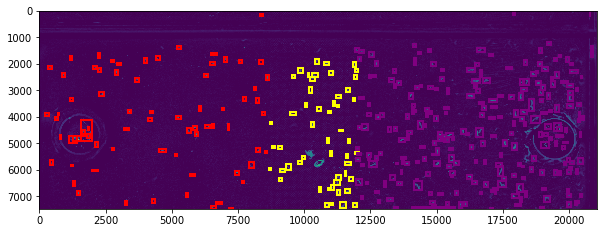

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(bkg_subtract)

for index, row in left_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

for index, row in middle_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='yellow', linewidth=2)
    ax.add_patch(rect)
    
for index, row in right_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='purple', linewidth=2)
    ax.add_patch(rect)
    
# ax.set_ylim(3500, 4500)
# ax.set_xlim(2500, 3500);
fig.savefig('../filtered_regions.pdf')

## Calculate chemotaxis index

In [30]:
worms_in_left_region = len(left_side_worms.index)
worms_in_middle_region = len(middle_worms.index)
worms_in_right_region = len(right_side_worms.index)
total_worms_found = len(filtered_regions.index)

chemotaxis_index_l = worms_in_left_region / total_worms_found
chemotaxis_index_r = worms_in_right_region / total_worms_found
print('Left chemotaxis index is', str(chemotaxis_index_l))
print('Right chemotaxis index is', str(chemotaxis_index_r))

Left chemotaxis index is 0.1994459833795014
Right chemotaxis index is 0.6592797783933518


# Diagnostic plots

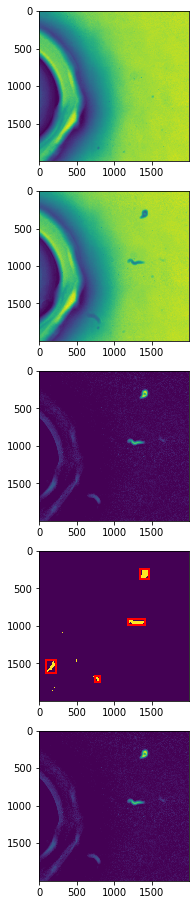

In [11]:
x_min = 2000
x_max = 4000
y_min = 3500
y_max = 5500

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 16))
axes[0].imshow(pre_image[y_min:y_max, x_min:x_max])
axes[1].imshow(fin_image[y_min:y_max, x_min:x_max])
axes[2].imshow(bkg_subtract[y_min:y_max, x_min:x_max])
axes[3].imshow(binarized[y_min:y_max, x_min:x_max])

axes[4].imshow(bkg_subtract[y_min:y_max, x_min:x_max])
for index, row in left_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    minr -= y_min
    minc -= x_min
    maxr -= y_min
    maxc -= x_min
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    axes[3].add_patch(rect)
#     (min_row, min_col, max_row, max_col)
#     (5893, 2717, 6005, 2825)

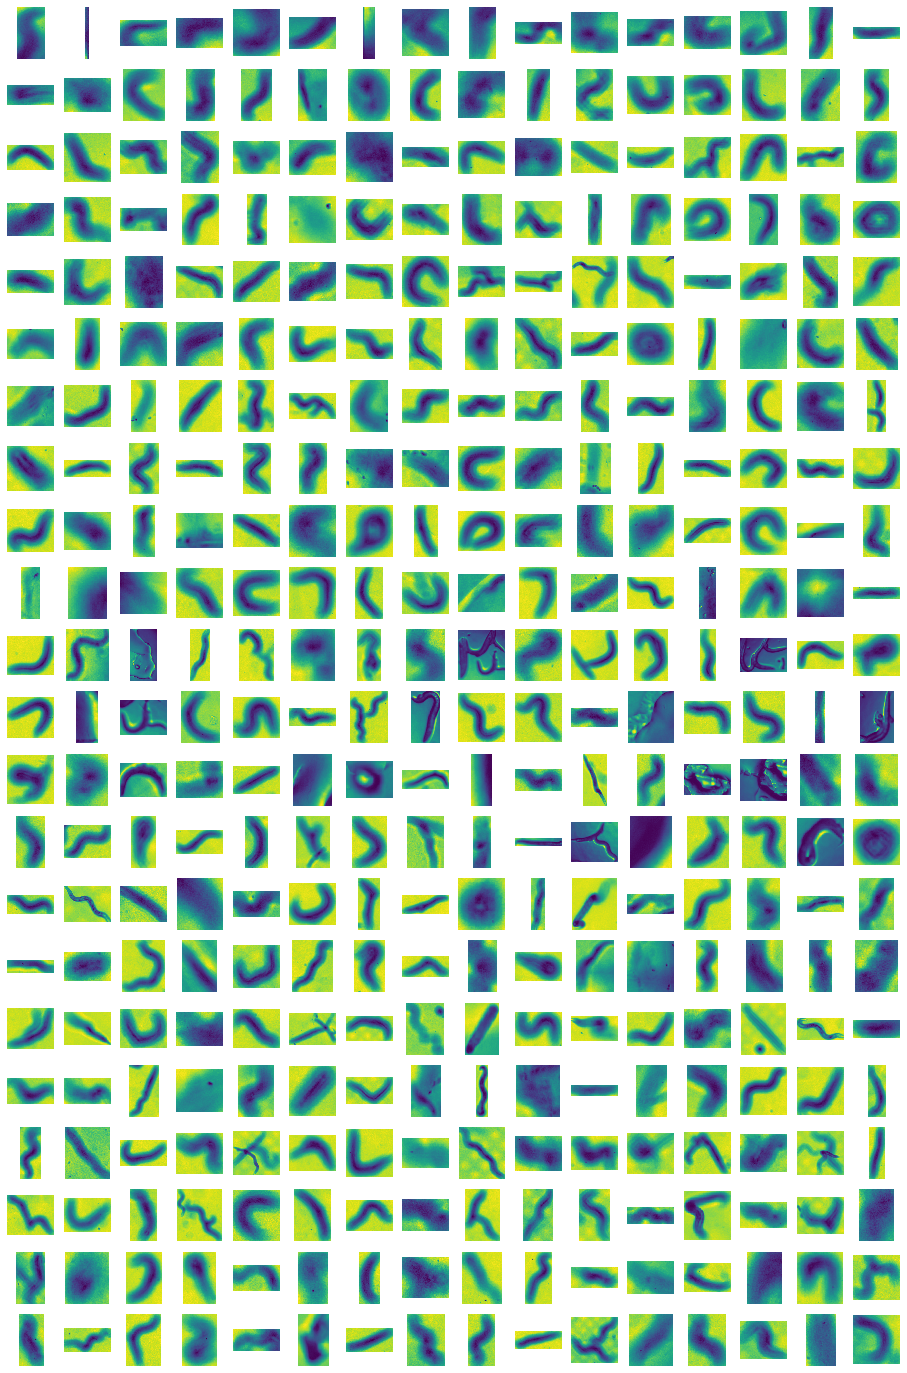

In [34]:
nrows = int(len(filtered_regions) / 16)
fig, axes = plt.subplots(nrows=nrows, ncols=16, figsize=(16, 25))
pad = 0
bboxes = filtered_regions['bbox'].values
region_num = 0
for row in range(0,nrows):
    for col in range(0,16):
        bbox = bboxes[region_num]
        axes[row, col].imshow(fin_image[bbox[0]-pad:bbox[2]+pad,bbox[1]-pad:bbox[3]+pad])
        axes[row, col].axis('off')
        region_num += 1

In [13]:
# fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 10))
# axes[0].imshow(bkg_subtract[y_min:y_max, x_min:x_max])
# axes[1.imshow(binarized[y_min:y_max, x_min:x_max])
# fig.savefig('../binarized_section_of image.png')

In [14]:
# regions = morphology.watershed(image=bkg_subtract[3500:4500, 2500:3500],# watershed_line=True, 
#                                compactness=.01,#,#markers=labeled_array[3500:4500, 2500:3500],
#                                mask=binarized[3500:4500, 2500:3500])
# # print(str(int(time.time()-start)))
# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
# # axes[0].imshow(binarized[3500:4500, 2500:3500])
# axes.imshow(regions, cmap=plt.cm.gray)

In [15]:
# edges = feature.canny(bkg_subtract[3500:4500, 2500:3500], low_threshold=5, high_threshold=19, sigma=1)
# filled_worms = ndi.binary_fill_holes(edges)#, structure=np.ones((3,3)))

In [16]:
# fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 20))
# axes[0].imshow(edges, cmap=plt.cm.gray)
# axes[1].imshow(filled_worms, cmap=plt.cm.gray)

In [17]:
# plt.hist(pre_image.flatten(), bins=16)
# plt.show()

In [18]:
# plt.hist(fin_image.flatten(), bins=16)
# plt.show()

In [19]:
# plt.hist(bkg_subtract.flatten(), bins=16)
# plt.show()

In [20]:
print('Notebook ran in', str(int(time.time()-start)), 'seconds.')

Notebook ran in 240 seconds.
